In [1]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [2]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [3]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [4]:
all_data = pd.read_pickle('data/morbilidad_global.csv')

In [269]:
all_data = all_data[(all_data['YEAR']>=2018) & (all_data['YEAR']<2022)]

all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)
all_data['SECTOR'] = all_data['SECTOR'].apply(lambda x: 'PRIVATE' if x == 'PRIVADO' else 'PUBLIC')


In [270]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,IS_LIMA,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVATE
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVATE
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVATE
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVATE
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,True,PRIVATE


In [271]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

In [272]:
name = "gist_rainbow"
name = "jet"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnostics_tag)))

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    if d == 'Codes for special situations':
        dict_colors[d]='#000000'
    else:
        dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [273]:
colors

array([[0.00000000e+00, 0.00000000e+00, 5.00000000e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.96078431e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.09982175e-01, 1.00000000e+00],
       [0.00000000e+00, 3.33333333e-02, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.21568627e-01, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 4.09803922e-01, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 5.82352941e-01, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 7.70588235e-01, 1.00000000e+00, 1.00000000e+00],
       [4.74383302e-02, 9.58823529e-01, 9.20303605e-01, 1.00000000e+00],
       [1.86590765e-01, 1.00000000e+00, 7.81151170e-01, 1.00000000e+00],
       [3.38393422e-01, 1.00000000e+00, 6.29348514e-01, 1.00000000e+00],
       [4.90196078e-01, 1.00000000e+00, 4.77545857e-01, 1.00000000e+00],
       [6.29348514e-01, 1.00000000e+00, 3.38393422e-01, 1.00000000e+00],
       [7.81151170e-01, 1.00000000e+00, 1.86590765e

In [274]:
cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
# new_colors = []
# for i in range(len(colorsc)):
#     new_colors.append(colorsc[i])
#     new_colors.append(colorsb[i])

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [275]:
dict_colors

{'Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified': '#31a354',
 'Codes for special situations': '#74c476',
 'Congenital malformations, deformities and chromosomal abnormalities': '#a1d99b',
 'Digestive system diseases': '#c7e9c0',
 'Diseases of the blood and hematopoietic organs and other disorders affecting the mechanism of immunity': '#756bb1',
 'Diseases of the circulatory system': '#9e9ac8',
 'Diseases of the ear and mastoid process': '#bcbddc',
 'Diseases of the eye and its adnexa': '#dadaeb',
 'Diseases of the genitourinary system': '#393b79',
 'Diseases of the musculoskeletal system and connective tissue': '#5254a3',
 'Diseases of the skin and subcutaneous tissue': '#6b6ecf',
 'Endocrine, nutritional and metabolic diseases': '#9c9ede',
 'External causes of morbidity and mortality': '#637939',
 'Factors influencing health status and contact with health services': '#8ca252',
 'Injuries, poisoning and some other consequences of external caus

#### ALL PERU

In [276]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

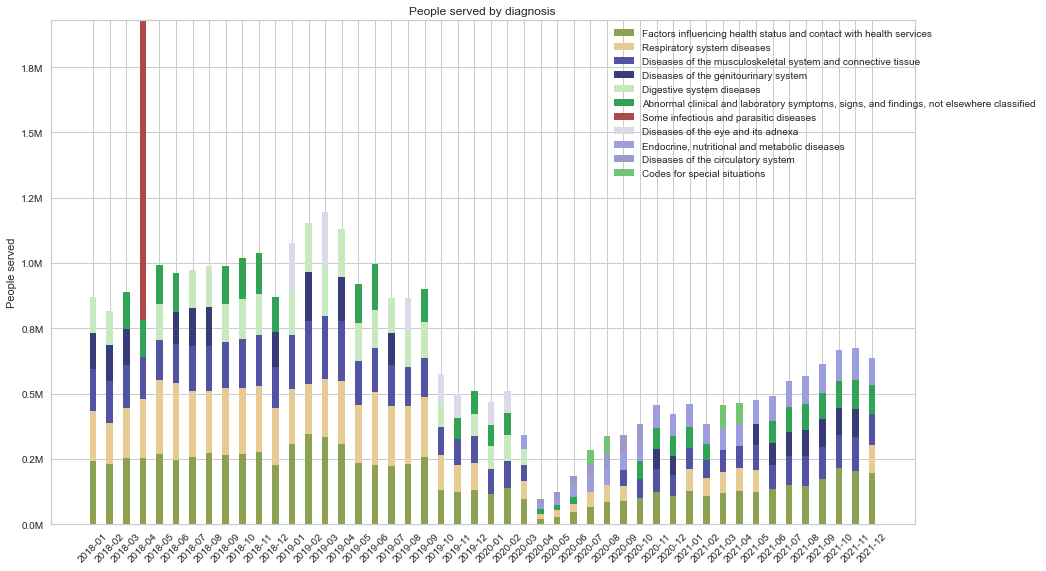

In [277]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Lima and Peru

In [278]:
PARAMETER = 'IS_LIMA'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

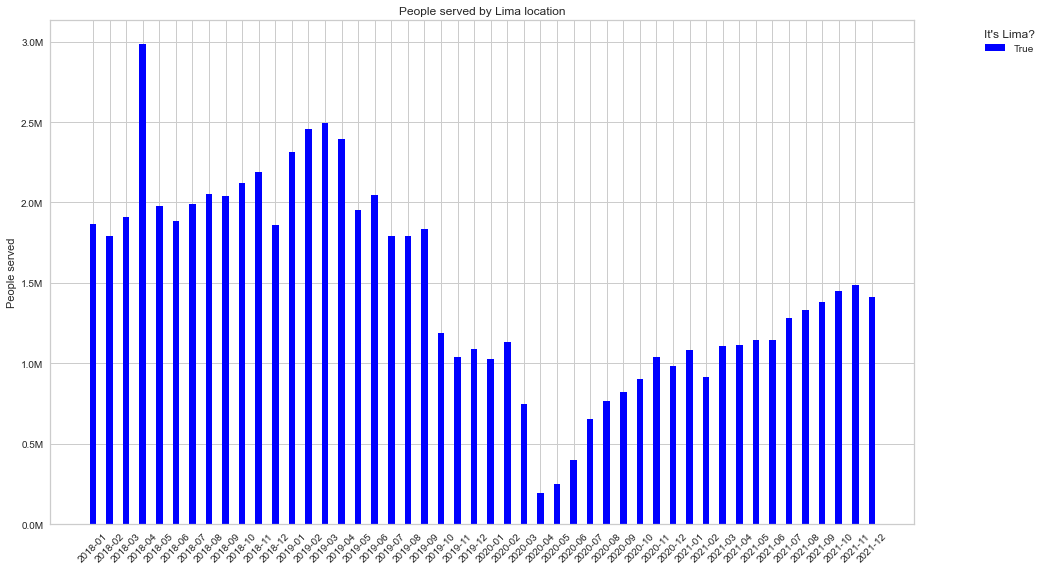

In [279]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), title = "It's Lima?")
plt.show()

# Only Lima

In [280]:
all_data = all_data[all_data['IS_LIMA']==True]

In [281]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

### Top 10 diagnosis 

In [282]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


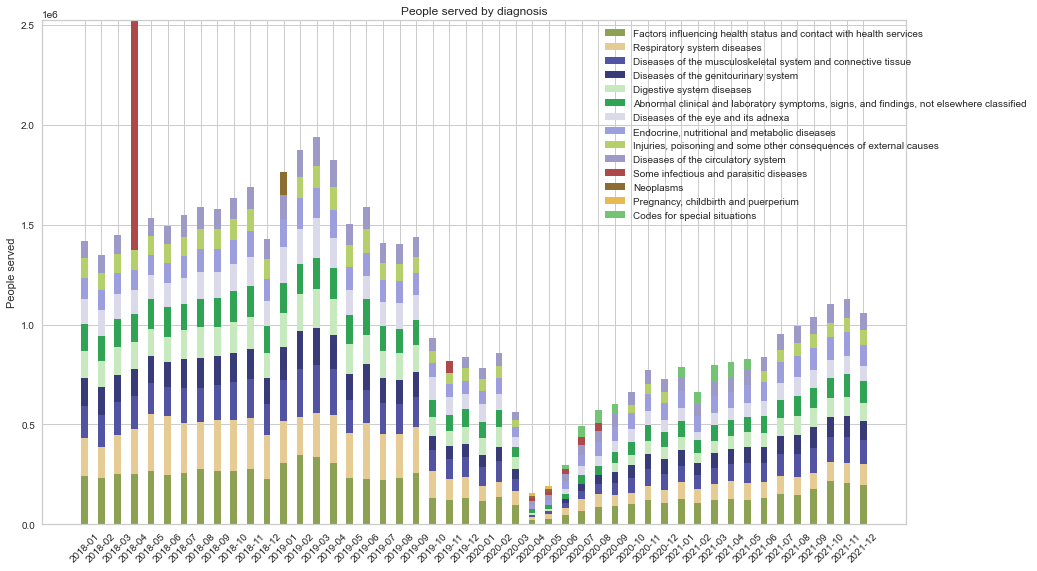

In [283]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40


fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45) 

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

## Estudio por categorias y diagnosticos

In [284]:
import plotly.express as px

In [285]:
def top_of_df(data, top = 5):
    df = data.copy()
    for row in range(len(df)):
        list_values = df.loc[row, columns_name].values
        top_values = list(-np.sort(-list_values)[:top])

        for i in range(list_values.size):
            val = list_values[i]
            if val in top_values:
                df.iloc[[row],i+1] = val
            else:
                df.iloc[[row],i+1] = 0
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.replace(0,np.nan)
    return df

In [286]:
all_data['CATEGORY2'].unique()

array(['II', '0', 'III', 'I'], dtype=object)

In [386]:
CATEGORIA_STUDIO = 'II'

### Private & Public 

In [387]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [388]:
df = data_temp
columns_name = list(df.columns)[1:]
fig = px.line(df, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %M"},
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total people served to Category ' + CATEGORIA_STUDIO)

# fig = px.scatter(data_temp, x="DATE", y=data_temp.columns,
#               hover_data={"DATE": "|%Y %M"},
#               labels={
#                      "value": "People served (qty)",
#                      "DATE": "Date",
#                      "SECTOR2": "Sector"
#                  },
#               title='Total people served to Category ' + CATEGORIA_STUDIO)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()

In [389]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR','DISEASE_GROUP'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [390]:
df = pd.concat([data_temp['DATE'],data_temp['PRIVATE']], axis=1)
#df = top_of_df(df, top = 10)

columns_name = list(df.columns)[1:]
columns_colors = [dict_colors[i] for i in columns_name]


# fig = px.line(df, x="DATE", y=columns_name,
#               hover_data={"DATE": "|%B %d, %Y"},
#               color_discrete_sequence=columns_colors,
#               labels={
#                      "value": "People served (qty)",
#                      "DATE": "Date",
#                      "SECTOR2": "Sector"
#                  },
#               title='Diagnosis to Category ' + CATEGORIA_STUDIO + ' (PRIVADO)',
#               width=800, height=1000)

fig = px.scatter(df, x="DATE", y=columns_name,
                 hover_data={"DATE": "|%Y %M"},
                 color_discrete_sequence=columns_colors,
                 labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "SECTOR": "Sector"
                 },
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (PRIVATE)',
                 width=1000, height=1000)

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.3,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()

In [391]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

In [392]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="QTY_PEOPLE_SERVED", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO,
            )
        
fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("results/Sector_"+CATEGORIA_STUDIO+".html")

### Normalized by Hospital and People (qty)

In [393]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]


data_hosp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_hosp = data_hosp.reset_index()
data_hosp =  data_hosp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': "count"})
data_hosp = data_hosp.reset_index()

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_pers =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_pers = data_pers.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = pd.merge(data_temp, data_hosp, how='inner', on=('DATE','SECTOR'))
data_temp['NORMAL_HOSPITAL'] = data_temp['QTY_PEOPLE_SERVED']/data_temp['CO_IPRESS']


data_temp = pd.merge(data_temp, data_pers, how='inner', on=('DATE','SECTOR'))
data_temp['NORMAL_PEOPLE'] = data_temp['QTY_PEOPLE_SERVED_x']/data_temp['QTY_PEOPLE_SERVED_y']


#### Graph to Normalized by hospital

In [394]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMAL_HOSPITAL", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
            )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("results/Sector_Normalized_Hospitals_"+CATEGORIA_STUDIO+".html")

In [395]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMAL_HOSPITAL", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
             )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("results/Sector_Normalized_Hospitals_Cat"+CATEGORIA_STUDIO+"_bar.html")

#### Graph to Normalized by people

In [396]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMAL_PEOPLE", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)',
            )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("results/Sector_Normalized_People_Cat"+CATEGORIA_STUDIO+"_bar.html")

In [397]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMAL_PEOPLE", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)'
             )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("results/Sector_Normalized_People_Cat"+CATEGORIA_STUDIO+"_line.html")

### Forecast

In [161]:
import plotly.io as pio 
import plotly.graph_objects as go

In [296]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [297]:
private_max = data_temp['PRIVATE'].mean() + 1*data_temp['PRIVATE'].std()
private_min = data_temp['PRIVATE'].mean() - 1*data_temp['PRIVATE'].std()

data_temp['PRIVATE_PURE'] = data_temp['PRIVATE'].apply(lambda x :
                                                       0 if (private_min>x or
                                                             private_max<x)
                                                       else x)

public_max = data_temp['PUBLIC'].mean() + 1*data_temp['PUBLIC'].std()
public_min = data_temp['PUBLIC'].mean() - 1*data_temp['PUBLIC'].std()

data_temp['PUBLIC_PURE'] = data_temp['PUBLIC'].apply(lambda x :
                                                       0 if (public_min>x or
                                                             public_max<x)
                                                       else x)



In [164]:
post_pandemic_df = data_temp[(data_temp['DATE'] > '2020-03')]
post_pandemic_df.head()

SECTOR2,DATE,PRIVATE,PUBLIC,PRIVATE_PURE,PUBLIC_PURE
27,2020-04-01,1126,859,1126,859
28,2020-05-01,2017,1720,2017,1720
29,2020-06-01,3533,2674,3533,2674
30,2020-07-01,9498,2720,9498,2720
31,2020-08-01,10421,4952,10421,4952


#### PRIVATE

<AxesSubplot:>

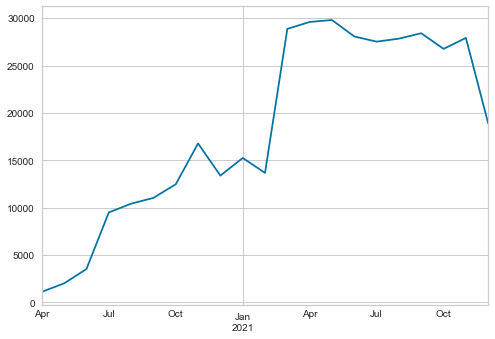

In [165]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PRIVATE'].values
df_series = pd.Series(data = data_to, index = index)
df_series.plot()

,Description,Value
0,session_id,7686
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(21, 1)"
5,Train data shape,"(20, 1)"
6,Test data shape,"(1, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


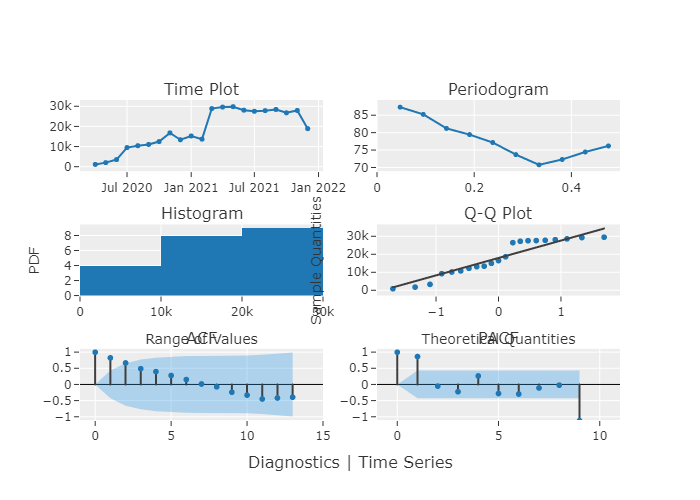

In [166]:
from pycaret.time_series import *
setup(data=df_series)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [167]:
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

NaiveForecaster()

In [ ]:
#best_baseline_models = 'auto_arima'
the_model = create_model('auto_arima')
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
#final_best = finalize_model(best_baseline_models)
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})

#### PUBLIC

In [ ]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PUBLIC'].values
df_series = pd.Series(data = data_to, index = index)
df_series.plot()

,Description,Value
0,session_id,1480
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(21, 1)"
5,Train data shape,"(20, 1)"
6,Test data shape,"(1, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


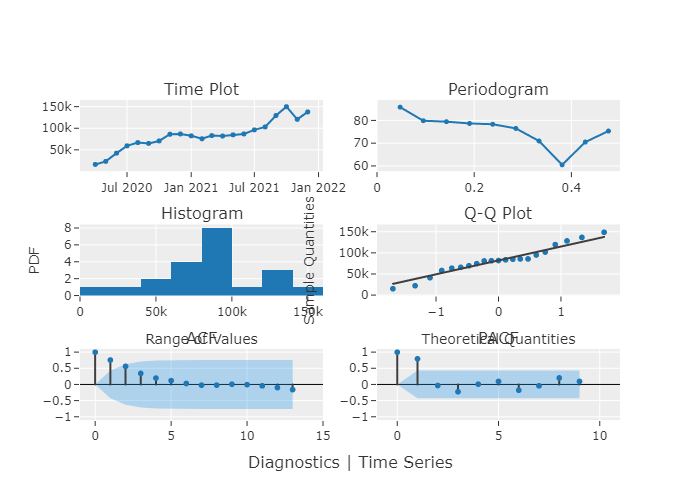

In [143]:
from pycaret.time_series import *
setup(data=df_series)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [144]:
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

BaseCdsDtForecaster(regressor=LGBMRegressor(random_state=1480), window_length=1)

In [145]:
#best_baseline_models = 'auto_arima'
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE
0,2021-08,19007.1251,19007.1251,0.1468,0.1584,2.6415,2.1049
1,2021-09,30914.8329,30914.8329,0.2062,0.2299,3.7138,2.8497
2,2021-10,9393.7500,9393.7500,0.0778,0.0749,1.0440,0.8103
Mean,nan,19771.9027,19771.9027,0.1436,0.1544,2.4664,1.9216
SD,nan,8802.5722,8802.5722,0.0525,0.0633,1.0970,0.8426


BaseCdsDtForecaster(regressor=LGBMRegressor(random_state=1480), window_length=1)


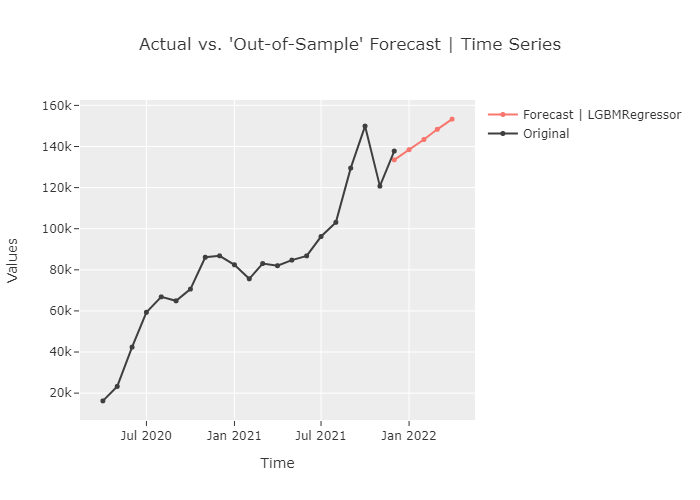

In [146]:
final_best = finalize_model(best_baseline_models)
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})